In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# All Functions

In [79]:
L = 128 # This value will determine the length of the codebook

def get_image_blocks(img: np.ndarray, size=4) -> np.ndarray:
    """Gets all the size x size blocks from the image in an array

    Args:
        img (np.ndarray): 
        size (int, optional): The size of the square block. Defaults to 4.

    Returns:
        np.ndarray: array of all the extracted blocks from the image 
    """
    h, w = img.shape

    # If the image is not even sized, then we will take only the
    # viable blocks
    h_fac, w_fac = h // size, w // size

    img_blocks = []
    for i in range(0, size*w_fac, size):
        for j in range(0, size*h_fac, size):
            img_blocks.append(img[j:j+size, i:i+size])

    img_blocks = np.array(img_blocks, dtype=object).reshape(-1, size, size)

    return img_blocks


def train(blocks: np.ndarray, codebook: np.ndarray) -> np.ndarray:
    """Trains the quantizer on the blocks of data and generates a codebook
    using the distortion of the blocks

    Args:
        blocks (np.ndarray): Array of all the blocks considered for training
        codebook (np.ndarray): Initial codebook

    Returns:
        np.ndarray: Final codebook
    """
    num_blocks = blocks.shape[0]
    size = blocks.shape[1]

    iterations = 100    # Total number of iterations to run if stopping criteria is not met

    for iter in range(iterations):
        code_vector = np.zeros(num_blocks)
        error_vector = np.zeros(num_blocks)

        # Loop through each block and check the error w.r.t each block in the codebook
        for i in range(num_blocks):
            block1 = blocks[i, :, :]
            errors = np.ones(L)

            for j in range(L):
                block2 = codebook[j, :, :]
                errors[j] = np.mean((block1 - block2)**2)

            # For each block, we find the block that gives the least error
            code_vector[i] = np.argmin(errors)
            error_vector[i] = np.amin(errors)

        # Calculate mean distortion
        d1 = np.mean(error_vector)

        # create codebook by selecting the image block that matches the least
        # error for each block in the codebook. 
        # The loop is stopped if the distortions between 2 iterations is less
        # than a certain threshold 
        if iter == 0 or np.abs(d1 - d0) / d0 >= 0.01:
            for l in range(L):
                if any(code_vector == l):
                    codebook[l] = np.mean(blocks[code_vector == l], axis=0)
                else:
                    codebook[l] = np.zeros((size, size))

            d0 = d1 # Set d0 as the current mean, d1 will change to the new
            # mean in the next iteration
        else:
            break
    
    return codebook

def quantize_image(img: np.ndarray, 
                   codebook: np.ndarray, 
                   size=4) -> np.ndarray:
    """Quantize an image using the trained codebook

    Args:
        img (np.ndarray): Input image
        codebook (np.ndarray): Codebook generated by the train function
        size (int, optional): Size of the blocks to use. Defaults to 4.

    Returns:
        np.ndarray: Output vector quantized image
    """
    h, w = img.shape

    h_fac, w_fac = h // size, w // size
    output = np.zeros_like(img)

    for i in range(0, size*w_fac, size):
        for j in range(0, size*h_fac, size):
            block1 = img[j:j+size, i:i+size]
            errors = np.ones(L)

            for l in range(L):
                block2 = codebook[l]
                errors[l] = np.mean((block1 - block2)**2)
            
            # The output size by size block will be chosen as the block from 
            # the codebook that has the lowest distortion
            output[j:j+size, i:i+size] = codebook[np.argmin(errors)]

    return output

def psnr(orig: np.ndarray, comp: np.ndarray) -> np.float32:
    """ This function calculates the PSNR of the original and the reconstructed image

    Args:
        orig (np.ndarray): Original image
        comp (np.ndarray): Constructed image

    Returns:
        np.float32: PSNR
    """
    mse = np.mean((orig - comp) ** 2)
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))
    
    return psnr

# Training

In [83]:
path = './train_images/'    # Path for train images

# Get blocks from all the training images
blocks = []
for file in os.listdir(path):
    if '.png' in file:
        img = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
        blocks.append(get_image_blocks(img))

blocks = np.vstack(blocks)
print(blocks.shape)

# Generate initial codebook
codebook = np.arange(0, 256, 256 // L).reshape((-1, 1))
codebook = np.tile(codebook, 16).reshape((-1, 4, 4))

# Train using the train images and obtain the final codebook
codebook = train(blocks, codebook)

(16384, 4, 4)


# Testing

In [84]:
img_path = './test_images/' # Folder of test images
img = cv2.imread(os.path.join(img_path, 'airplane.png'), cv2.IMREAD_GRAYSCALE)

# Quantize the test image using the codebook generated after training
output = quantize_image(img, codebook)

# Output

Plot the original image and the quantized image

33.6392327471148


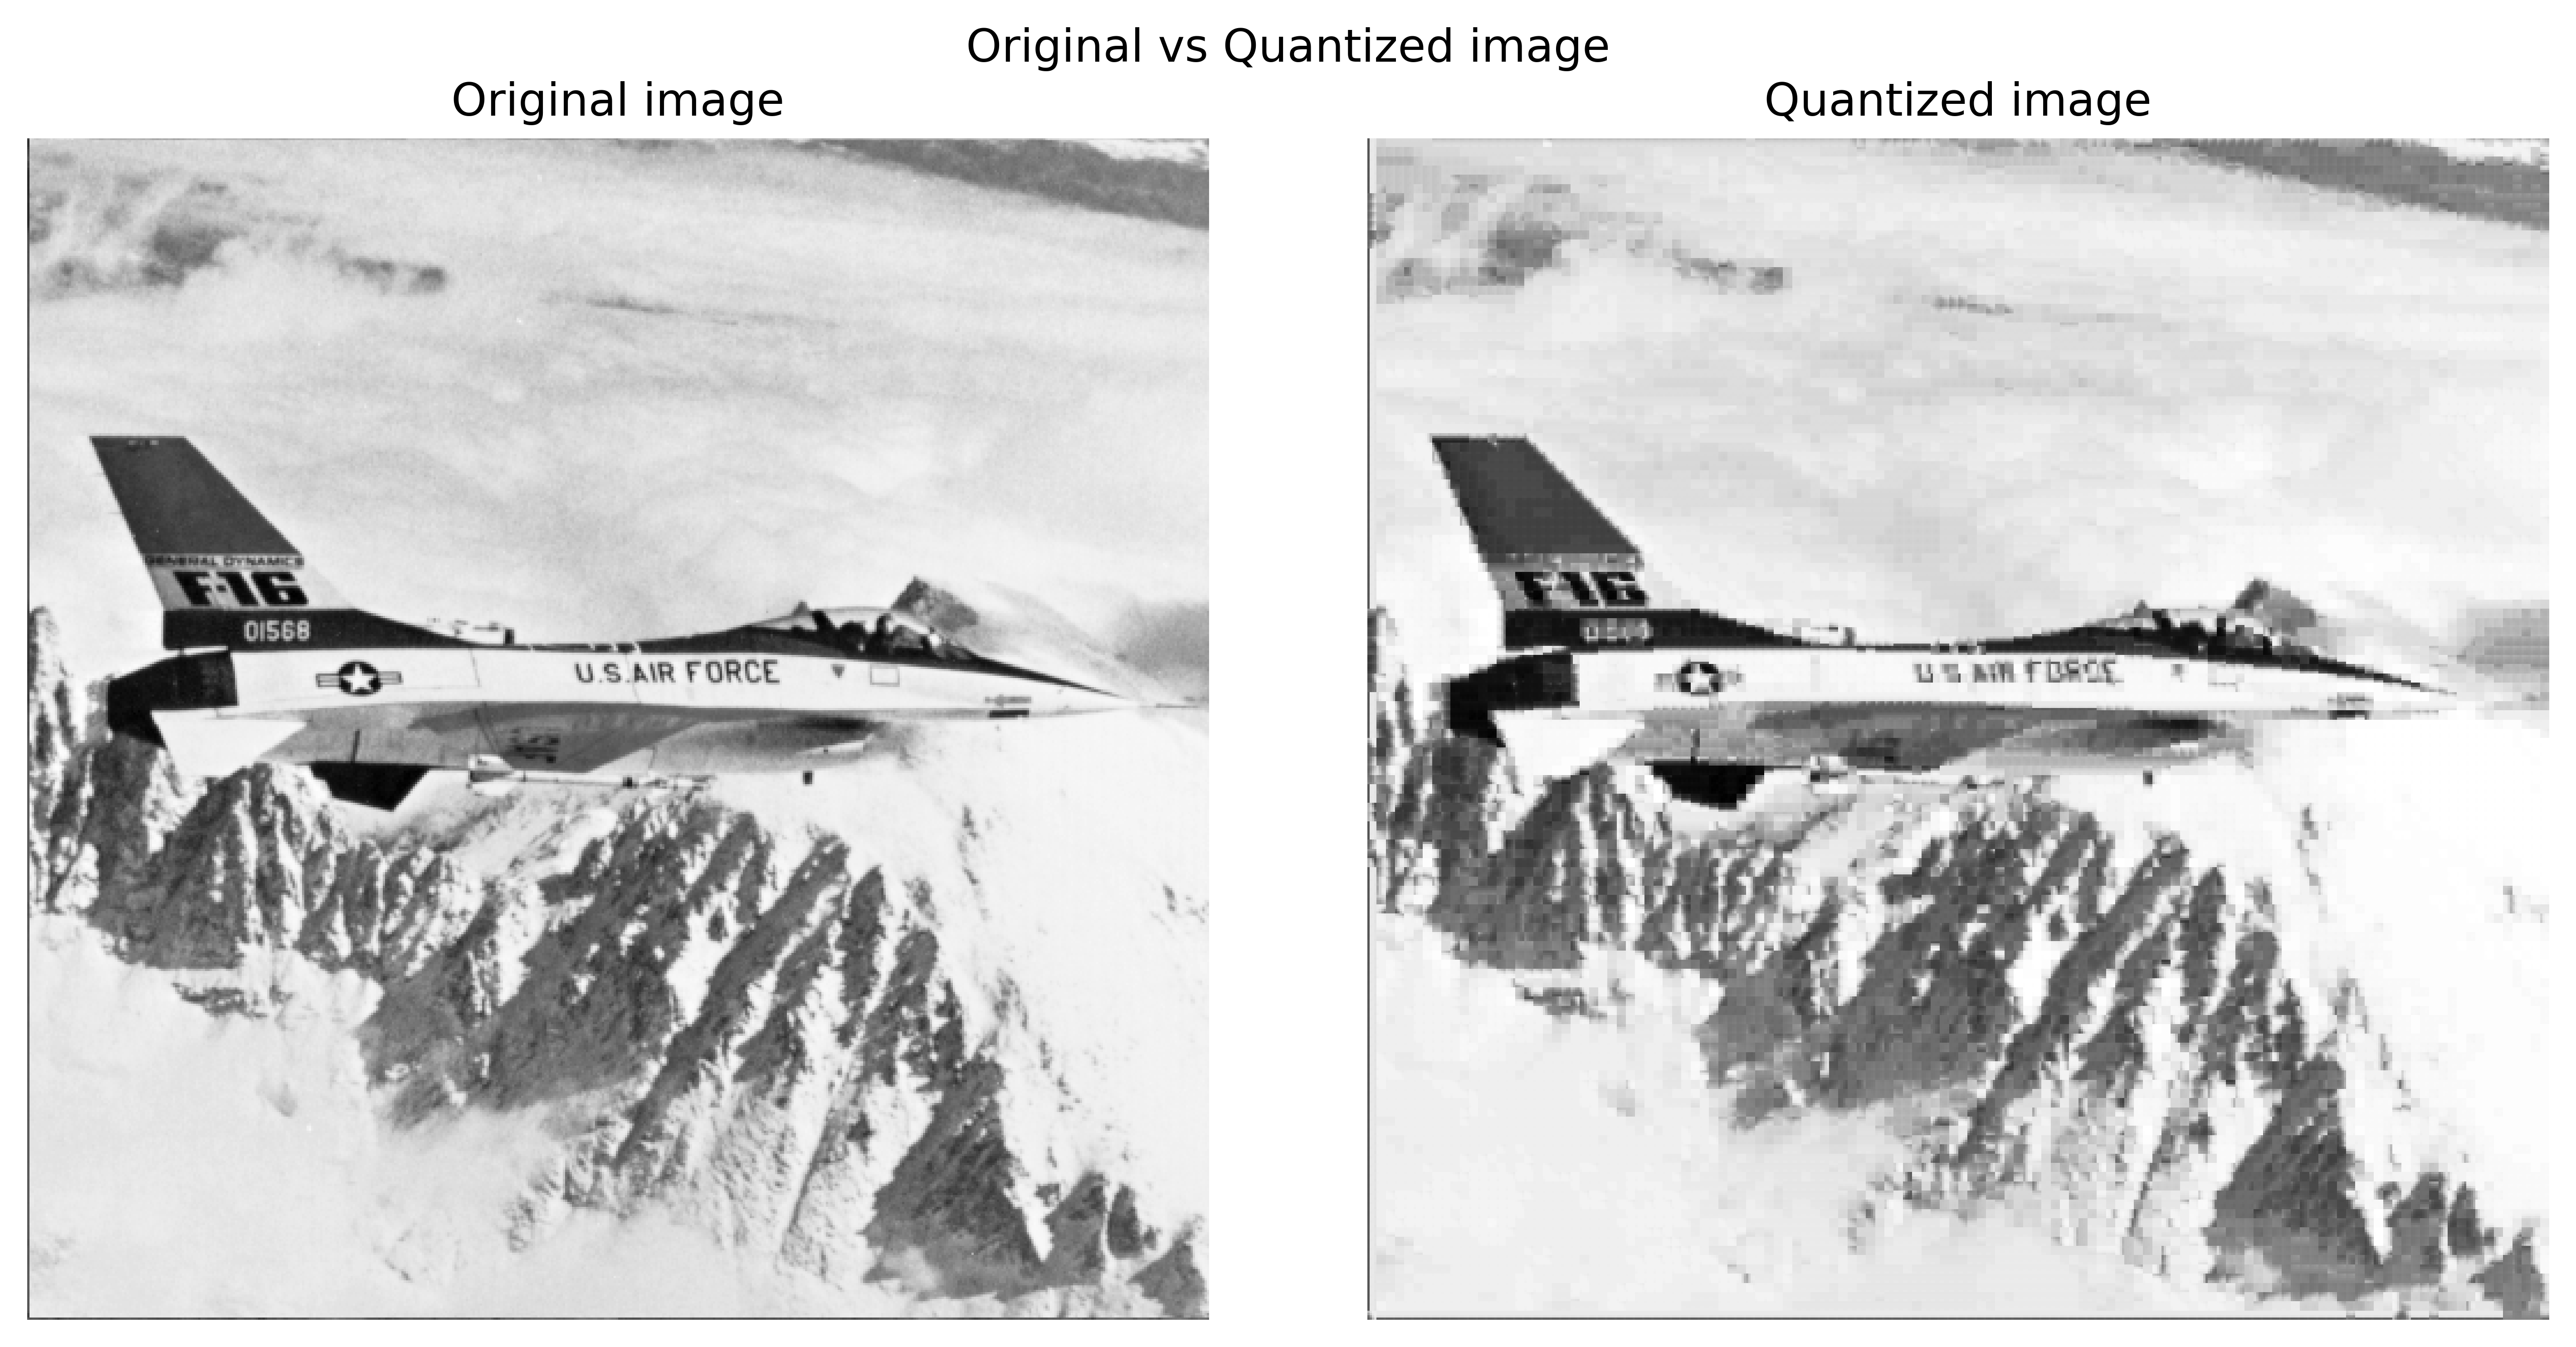

In [85]:
plt.figure(dpi=600, figsize=(10,5))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Original image')

plt.subplot(122)
plt.axis('off')
plt.imshow(output, cmap='gray')
plt.title('Quantized image')

plt.suptitle('Original vs Quantized image')
plt.tight_layout()
psnr_val = psnr(img, output)
print(psnr_val)